# Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Thesis/'

/content/drive/MyDrive/Thesis


In [3]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print('Device in use:', device)

Device in use: cuda


# Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import functools
# For the neural networks
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# For working with images
from PIL import Image
import io
from IPython.display import Image as IPImage, display

# Flow Matching

## Random dataset

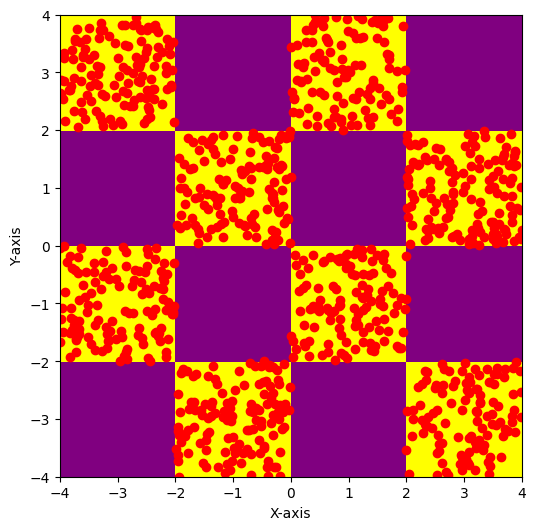

In [ ]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)

    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)

    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

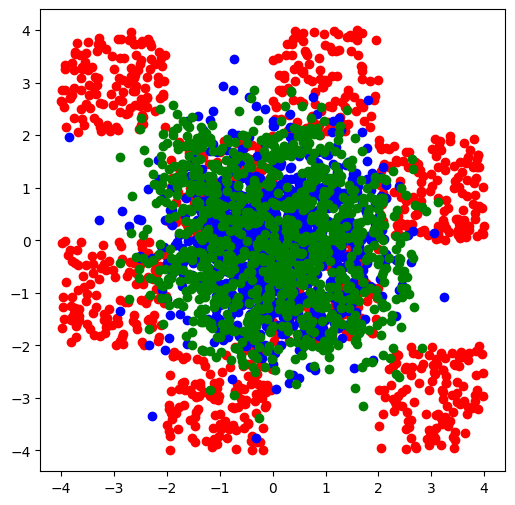

In [ ]:
t = 0.5
noise = np.random.randn(N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.scatter(noise[:, 0], noise[:, 1], color="blue", marker="o")
plt.scatter((1 - t) * noise[:, 0] + t * sampled_points[:, 0], (1 - t) * noise[:, 1] + t * sampled_points[:, 1], color="green", marker="o")
plt.show()

In [ ]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [ ]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
data = torch.Tensor(sampled_points)
training_steps = 100_000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # also add t here
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 100000/100000 [1:12:37<00:00, 22.95it/s, loss=3.34]


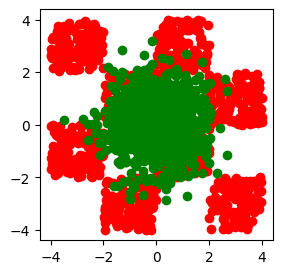

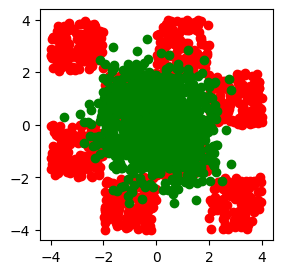

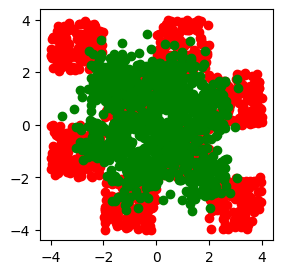

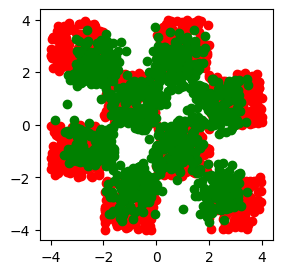

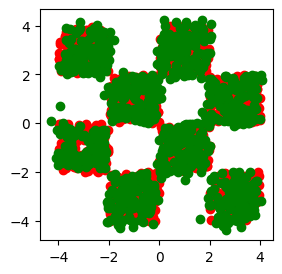

Done Sampling


In [ ]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1000, 2)
steps = 1000
plot_every = 200
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(3,3))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
        plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o")
        plt.show()
model.train().requires_grad_(True)
print("Done Sampling")

## MNIST

### Uncoditioned

#### Training

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, T):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.randn_like(x_1)
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_comp = match_last_dims(t, x_start.shape)
    x_t =(1-t_comp) * x_0 + t_comp * x_1

    t_norm = t/T

    pred = model(x_t, t_norm)
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "flow_matching_unconditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Training on device: cuda
Epoch [1] Average Loss: 0.2962
Epoch [2] Average Loss: 0.2403
Epoch [3] Average Loss: 0.2307
Epoch [4] Average Loss: 0.2248
Epoch [5] Average Loss: 0.2216
Epoch [6] Average Loss: 0.2207
Epoch [7] Average Loss: 0.2184
Epoch [8] Average Loss: 0.2161
Epoch [9] Average Loss: 0.2149
Epoch [10] Average Loss: 0.2146
Epoch [11] Average Loss: 0.2120
Epoch [12] Average Loss: 0.2126
Epoch [13] Average Loss: 0.2114
Epoch [14] Average Loss: 0.2121
Epoch [15] Average Loss: 0.2105
Epoch [16] Average Loss: 0.2103
Epoch [17] Average Loss: 0.2085
Epoch [18] Average Loss: 0.2106
Epoch [19] Average Loss: 0.2095
Epoch [20] Average Loss: 0.2083
Epoch [21] Average Loss: 0.2082
Epoch [22] Average Loss: 0.2084
Epoch [23] Average Loss: 0.2062
Epoch [24] Average Loss: 0.2092
Epoch [25] Average Loss: 0.2071
Epoch [26] Average Loss: 0.2061
Epoch [27] Average Loss: 0.2063
Epoch [28] Average Loss: 0.2063
Epoch [29] Average Loss: 0.2060
Epoch [30] Average Loss: 0.2058
Epoch [31] Average Loss:

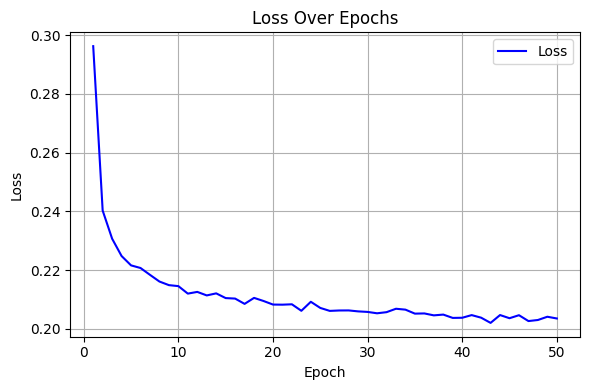

In [ ]:
train(
    num_epochs=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/flow_matching_unconditioned.pth")

#### Evaluation

In [ ]:
model.load_state_dict(torch.load("trained/flow_matching_unconditioned.pth"))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            xt = xt + (T / steps) * model(xt, t_norm_batch)

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [00:21<00:00, 22.96it/s]
<ipython-input-24-26a93b4bbe76>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


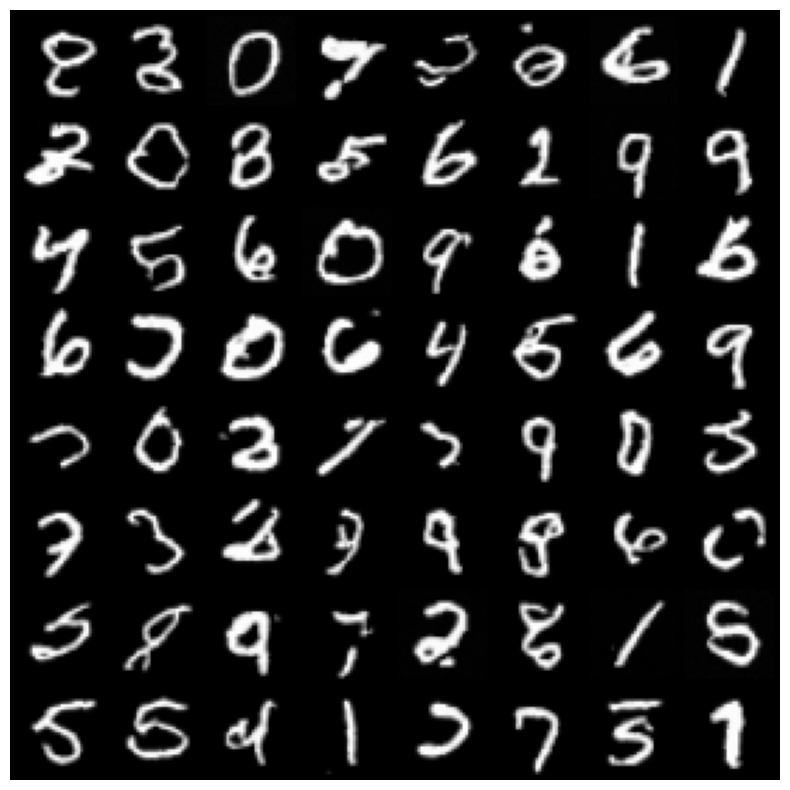

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    T=1,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=4,
    reverse_steps=500,
    schedule='linear',
    T=1,
    gif=True
)

# final_step_images = [s[-1].cpu().detach().numpy() for s in samples]

frames = []
for _, x_t in enumerate(samples):
    frame = make_grid(x_t, nrow=2, padding=2).permute(1, 2, 0).cpu().numpy()
    frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    frames.append(Image.fromarray(frame))

# Create GIF
buf = io.BytesIO()
frames[0].save(buf, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)
buf.seek(0)

# # Save GIF locally
# output_path = "unconditioned.gif"
# frames[0].save(output_path, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))

### Conditioned

#### Training

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.randn_like(x_1)
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_comp = match_last_dims(t, x_start.shape)
    x_t =(1-t_comp) * x_0 + t_comp * x_1

    t_norm = t/T
    pred = model(x_t, t_norm, y=y)
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data, y) in enumerate(dataloader):
            data = data.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, y=y, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "flow_matching_conditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Training on device: cuda
Epoch [1] Average Loss: 0.2746
Epoch [2] Average Loss: 0.2128
Epoch [3] Average Loss: 0.2041
Epoch [4] Average Loss: 0.1994
Epoch [5] Average Loss: 0.1957
Epoch [6] Average Loss: 0.1940
Epoch [7] Average Loss: 0.1917
Epoch [8] Average Loss: 0.1908
Epoch [9] Average Loss: 0.1905
Epoch [10] Average Loss: 0.1889
Epoch [11] Average Loss: 0.1881
Epoch [12] Average Loss: 0.1879
Epoch [13] Average Loss: 0.1860
Epoch [14] Average Loss: 0.1862
Epoch [15] Average Loss: 0.1855
Epoch [16] Average Loss: 0.1852
Epoch [17] Average Loss: 0.1857
Epoch [18] Average Loss: 0.1836
Epoch [19] Average Loss: 0.1831
Epoch [20] Average Loss: 0.1841
Epoch [21] Average Loss: 0.1833
Epoch [22] Average Loss: 0.1817
Epoch [23] Average Loss: 0.1820
Epoch [24] Average Loss: 0.1824
Epoch [25] Average Loss: 0.1818
Epoch [26] Average Loss: 0.1818
Epoch [27] Average Loss: 0.1814
Epoch [28] Average Loss: 0.1811
Epoch [29] Average Loss: 0.1795
Epoch [30] Average Loss: 0.1812
Epoch [31] Average Loss:

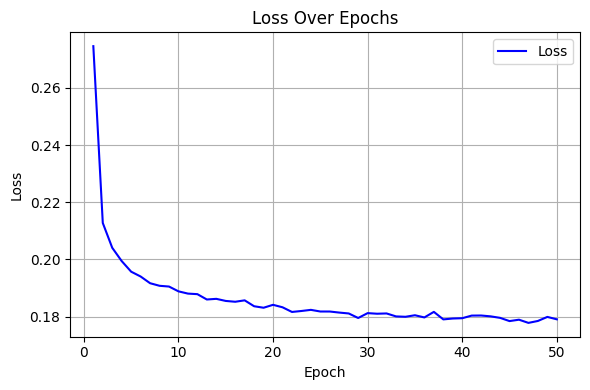

In [ ]:
train(
    num_epochs=50,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/flow_matching_conditioned.pth")

#### Evaluation

In [ ]:
model.load_state_dict(torch.load("trained/flow_matching_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T


            cond_class_label = torch.full((shape[0],), class_label, device=device)
            xt = xt + (T / steps) * model(xt, t_norm_batch, cond_class_label)

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [00:22<00:00, 22.71it/s]
<ipython-input-34-f445407aba4f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


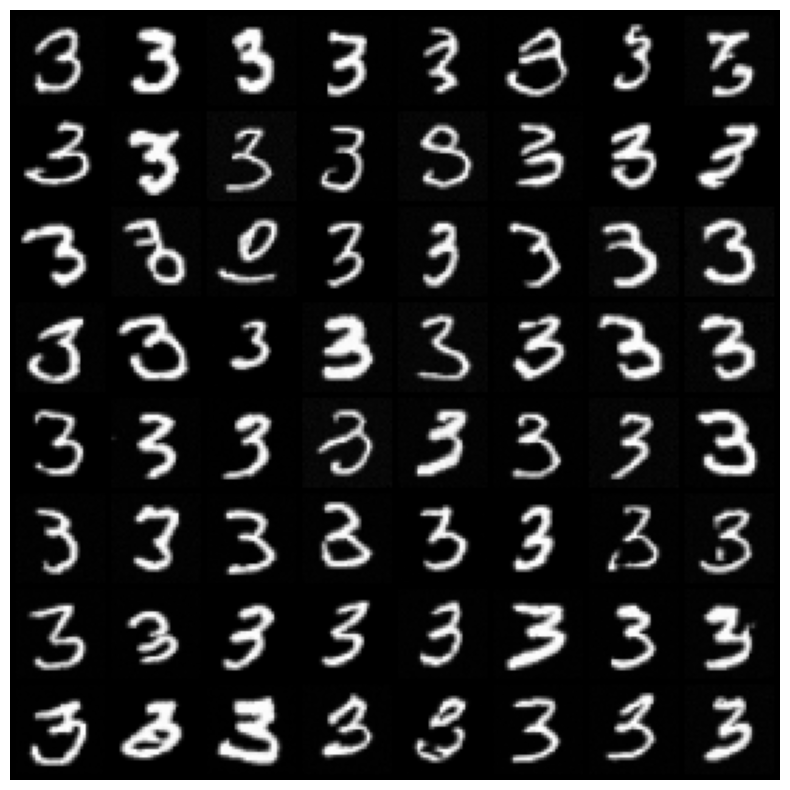

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    class_label=3,
    T=1,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:11<00:00, 42.55it/s]
<ipython-input-11-9cfb4968bd17>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
100%|██████████| 500/500 [00:11<00:00, 42.68it/s]


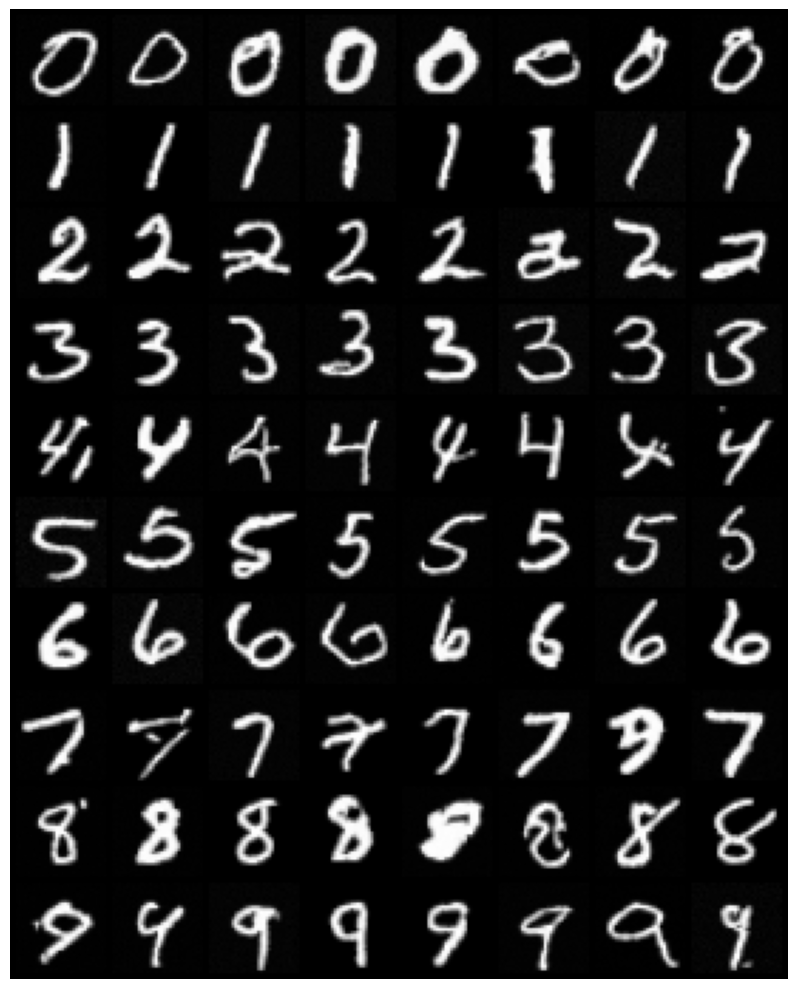

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Initialize an empty list to store all samples
all_samples = []

# Loop over digit classes 0 through 9
for class_label in range(10):
    samples = sample(
        model=model,
        n_samples=8,
        steps=500,
        class_label=class_label,
        T=1,
        gif=False
    )

    # Stack and collect final step images
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    all_samples.append(final_step_images)

# Concatenate all class sample tensors into one tensor of shape (80, C, H, W)
all_samples_tensor = torch.cat(all_samples, dim=0)

# Create a grid with 8 rows and 10 columns
grid = make_grid(all_samples_tensor, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(12, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:01<00:00, 45.42it/s]
<ipython-input-16-e74e0d346af0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_images.append(torch.tensor(sample_result[0]).cpu())
100%|██████████| 500/500 [00:11<00:00, 41.87it/s]


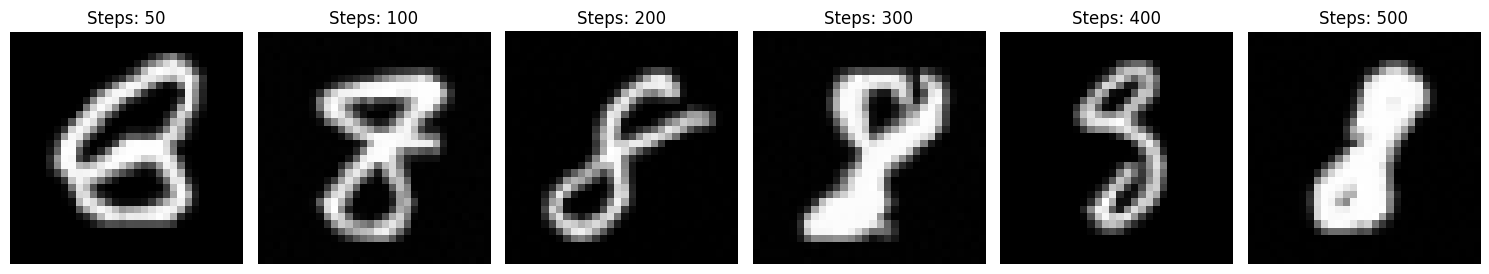

In [ ]:
import matplotlib.pyplot as plt
import torch

# List of steps at which to sample
steps_list = [50, 100, 200, 300, 400, 500]

# Collect one sample for each specified step count
sampled_images = []
for steps in steps_list:
    sample_result = sample(
        model=model,
        n_samples=1,
        steps=steps,
        class_label=8,
        T=1,
        gif=False
    )
    # Assume sample returns a list of numpy arrays or tensors
    sampled_images.append(torch.tensor(sample_result[0]).cpu())

# Plot each image individually
plt.figure(figsize=(15, 3))
for idx, image in enumerate(sampled_images):
    plt.subplot(1, len(steps_list), idx + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Steps: {steps_list[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## CIFAR10

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Tranformation for the CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Download the dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_loader = DataLoader(cifar10_dataset, batch_size=64, shuffle=True)

### Unconditional

#### Training

In [6]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [25]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=128,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [4, 8, 16],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [21]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [22]:
import torch.nn.functional as F

def loss_fn(model, x_start, T):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.randn_like(x_1)
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_comp = match_last_dims(t, x_start.shape)
    x_t =(1-t_comp) * x_0 + t_comp * x_1

    t_norm = t/T

    pred = model(x_t, t_norm)
    loss = F.mse_loss(pred, target)
    return loss

In [23]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "cifar_flow_matching_unconditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
train(
    num_epochs=3,
    dataloader=cifar10_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 4

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/cifar_flow_matching_unconditioned.pth")

#### Generation

In [ ]:
model.load_state_dict(torch.load("trained/cifar_flow_matching_unconditioned.pth"))

In [13]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            xt = xt + (T / steps) * model(xt, t_norm_batch)

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [01:10<00:00,  7.05it/s]
<ipython-input-14-f611c2ef3054>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


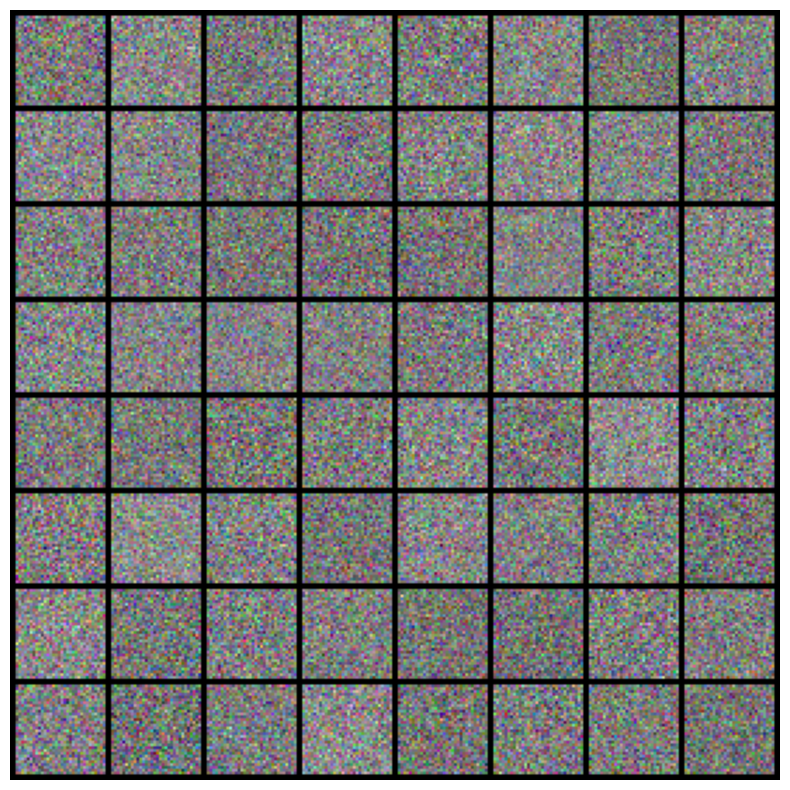

In [14]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    T=1,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=4,
    reverse_steps=500,
    schedule='linear',
    T=1,
    gif=True
)

# final_step_images = [s[-1].cpu().detach().numpy() for s in samples]

frames = []
for _, x_t in enumerate(samples):
    frame = make_grid(x_t, nrow=2, padding=2).permute(1, 2, 0).cpu().numpy()
    frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    frames.append(Image.fromarray(frame))

# Create GIF
buf = io.BytesIO()
frames[0].save(buf, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)
buf.seek(0)

# # Save GIF locally
# output_path = "unconditioned.gif"
# frames[0].save(output_path, format="GIF", append_images=frames[1:], save_all=True, duration=20, loop=0)

# Display GIF
display(IPImage(buf.read(), width=512, height=512))

### Conditional

#### Training

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]
    x_0 = torch.randn_like(x_1)
    target = x_1 - x_0
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_comp = match_last_dims(t, x_start.shape)
    x_t =(1-t_comp) * x_0 + t_comp * x_1

    t_norm = t/T
    pred = model(x_t, t_norm, y=y)
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data, y) in enumerate(dataloader):
            data = data.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, y=y, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "cifar_flow_matching_conditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Training on device: cuda
Epoch [1] Average Loss: 0.2746
Epoch [2] Average Loss: 0.2128
Epoch [3] Average Loss: 0.2041
Epoch [4] Average Loss: 0.1994
Epoch [5] Average Loss: 0.1957
Epoch [6] Average Loss: 0.1940
Epoch [7] Average Loss: 0.1917
Epoch [8] Average Loss: 0.1908
Epoch [9] Average Loss: 0.1905
Epoch [10] Average Loss: 0.1889
Epoch [11] Average Loss: 0.1881
Epoch [12] Average Loss: 0.1879
Epoch [13] Average Loss: 0.1860
Epoch [14] Average Loss: 0.1862
Epoch [15] Average Loss: 0.1855
Epoch [16] Average Loss: 0.1852
Epoch [17] Average Loss: 0.1857
Epoch [18] Average Loss: 0.1836
Epoch [19] Average Loss: 0.1831
Epoch [20] Average Loss: 0.1841
Epoch [21] Average Loss: 0.1833
Epoch [22] Average Loss: 0.1817
Epoch [23] Average Loss: 0.1820
Epoch [24] Average Loss: 0.1824
Epoch [25] Average Loss: 0.1818
Epoch [26] Average Loss: 0.1818
Epoch [27] Average Loss: 0.1814
Epoch [28] Average Loss: 0.1811
Epoch [29] Average Loss: 0.1795
Epoch [30] Average Loss: 0.1812
Epoch [31] Average Loss:

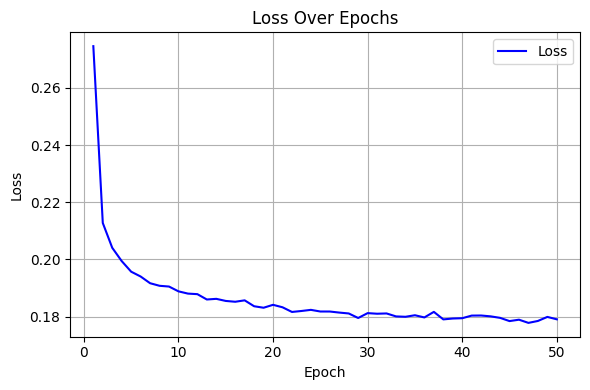

In [ ]:
train(
    num_epochs=50,
    dataloader=cifar_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/cifar_flow_matching_conditioned.pth")

#### Generation

In [ ]:
model.load_state_dict(torch.load("trained/cifar_flow_matching_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T


            cond_class_label = torch.full((shape[0],), class_label, device=device)
            xt = xt + (T / steps) * model(xt, t_norm_batch, cond_class_label)

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [00:22<00:00, 22.71it/s]
<ipython-input-34-f445407aba4f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


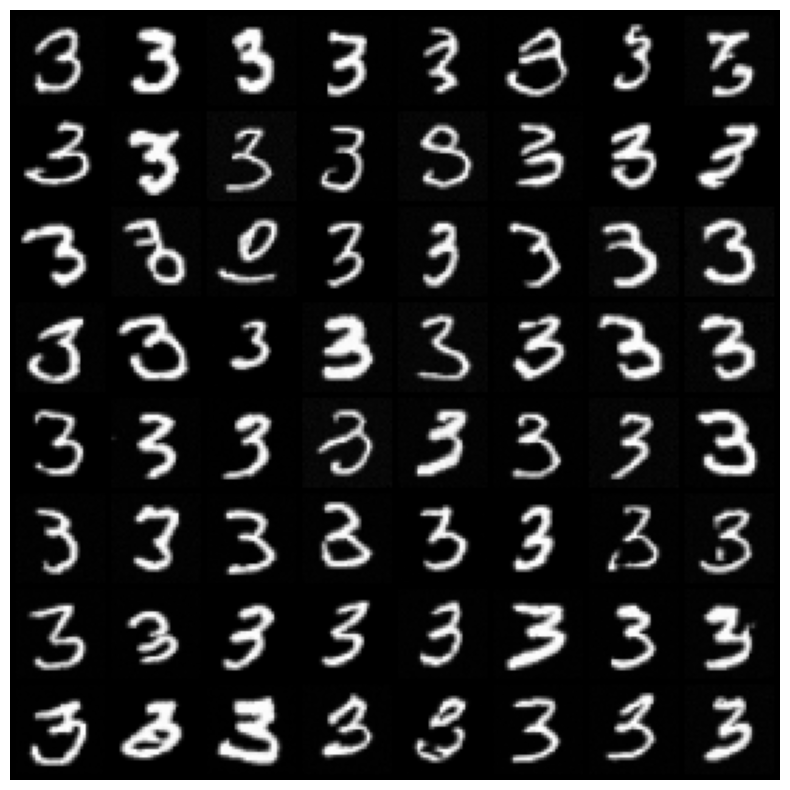

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    class_label=3,
    T=1,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:11<00:00, 42.55it/s]
<ipython-input-11-9cfb4968bd17>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
100%|██████████| 500/500 [00:11<00:00, 42.68it/s]


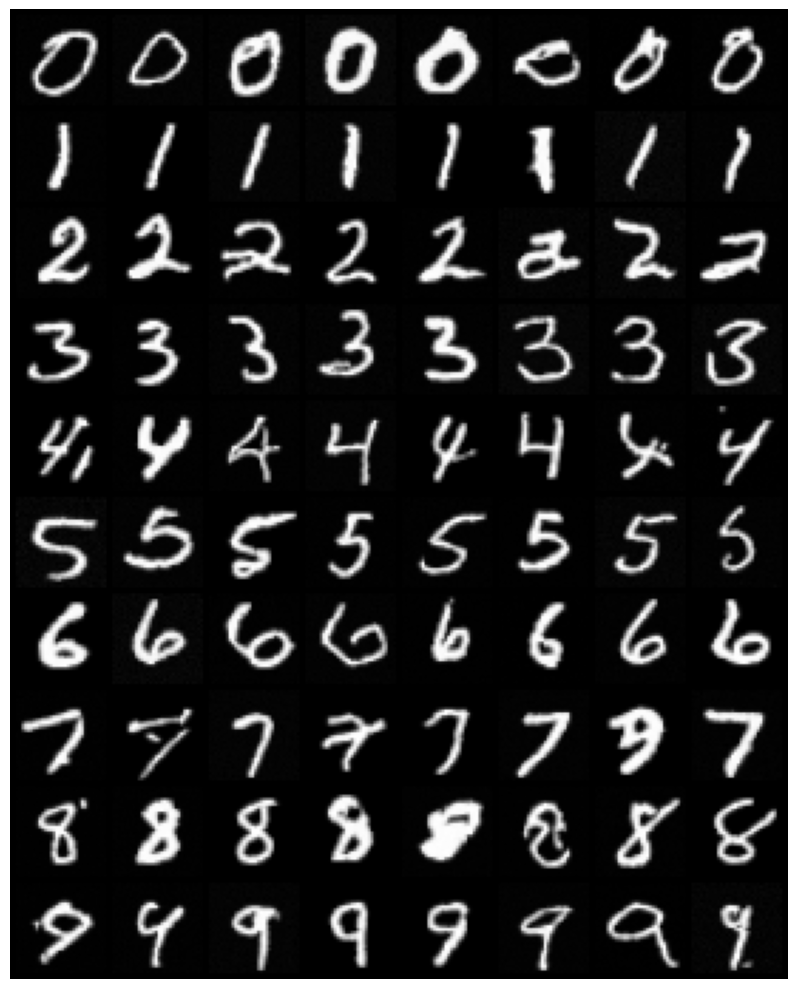

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Initialize an empty list to store all samples
all_samples = []

# Loop over digit classes 0 through 9
for class_label in range(10):
    samples = sample(
        model=model,
        n_samples=4,
        steps=500,
        class_label=class_label,
        T=1,
        gif=False
    )

    # Stack and collect final step images
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    all_samples.append(final_step_images)

# Concatenate all class sample tensors into one tensor of shape (80, C, H, W)
all_samples_tensor = torch.cat(all_samples, dim=0)

# Create a grid with 8 rows and 10 columns
grid = make_grid(all_samples_tensor, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(12, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:01<00:00, 45.42it/s]
<ipython-input-16-e74e0d346af0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_images.append(torch.tensor(sample_result[0]).cpu())
100%|██████████| 500/500 [00:11<00:00, 41.87it/s]


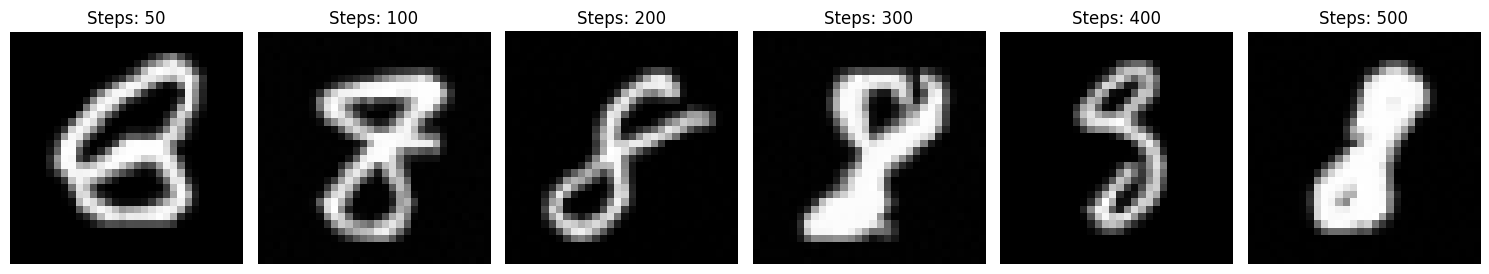

In [ ]:
import matplotlib.pyplot as plt
import torch

# List of steps at which to sample
steps_list = [50, 100, 200, 300, 400, 500]

# Collect one sample for each specified step count
sampled_images = []
for steps in steps_list:
    sample_result = sample(
        model=model,
        n_samples=1,
        steps=steps,
        class_label=8,
        T=1,
        gif=False
    )
    # Assume sample returns a list of numpy arrays or tensors
    sampled_images.append(torch.tensor(sample_result[0]).cpu())

# Plot each image individually
plt.figure(figsize=(15, 3))
for idx, image in enumerate(sampled_images):
    plt.subplot(1, len(steps_list), idx + 1)
    plt.imshow(image.squeeze())
    plt.title(f'Steps: {steps_list[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Bridge Matching

## MNIST

### Unconditioned

#### Training

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch
import torch.nn.functional as F

def loss_fn(model, x_start, sigma, T):
    """
    Bridge matching loss function.

    Args:
        model: The neural network model that predicts the drift term
        x_start: The target samples (x_1) from the data distribution
        T: The maximum time value (typically 1.0)

    Returns:
        The calculated loss value
    """
    device = x_start.device
    x_1 = x_start  # target samples from data distribution
    batch_size = x_start.shape[0]

    # Sample from the prior distribution (standard normal)
    x_0 = torch.randn_like(x_1)

    # Sample time uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_expanded = match_last_dims(t, x_start.shape)

    # Compute the conditional mean and std for the bridge process
    mean_t = (1 - t_expanded/T) * x_0 + (t_expanded/T) * x_1
    std_t = sigma * torch.sqrt((t_expanded * (T - t_expanded)) / T)

    # Sample from the bridge process at time t
    x_t = mean_t + std_t * torch.randn_like(x_0)

    # Compute the target
    target = x_1

    # Normalize time to [0, 1]
    t_norm = t / T

    # Model prediction
    pred = model(x_t, t_norm)

    # MSE loss between predicted and target drift
    loss = F.mse_loss(pred, target)

    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data,_) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, sigma=0.5, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "bridge_matching_unconditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
train(
    num_epochs=100,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.0286
Epoch [2] Average Loss: 0.0256
Epoch [3] Average Loss: 0.0253
Epoch [4] Average Loss: 0.0248
Epoch [5] Average Loss: 0.0247
Epoch [6] Average Loss: 0.0244
Epoch [7] Average Loss: 0.0243
Epoch [8] Average Loss: 0.0243
Epoch [9] Average Loss: 0.0244
Epoch [10] Average Loss: 0.0241
Epoch [11] Average Loss: 0.0239
Epoch [12] Average Loss: 0.0240
Epoch [13] Average Loss: 0.0240
Epoch [14] Average Loss: 0.0240
Epoch [15] Average Loss: 0.0238
Epoch [16] Average Loss: 0.0238
Epoch [17] Average Loss: 0.0237
Epoch [18] Average Loss: 0.0238
Epoch [19] Average Loss: 0.0237
Epoch [20] Average Loss: 0.0239
Epoch [21] Average Loss: 0.0237
Epoch [22] Average Loss: 0.0239
Epoch [23] Average Loss: 0.0236
Epoch [24] Average Loss: 0.0236
Epoch [25] Average Loss: 0.0237
Epoch [26] Average Loss: 0.0236
Epoch [27] Average Loss: 0.0235
Epoch [28] Average Loss: 0.0235
Epoch [29] Average Loss: 0.0237
Epoch [30] Average Loss: 0.0236
Epoch [31] Average Loss:

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/bridge_matching_unconditioned.pth")

#### Evaluation

In [ ]:
model.load_state_dict(torch.load("trained/bridge_matching_unconditioned.pth"))
# model.load_state_dict(torch.load("trained/bridge_matching_unconditioned.pth", map_location=torch.device('cpu')))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T
            noise = torch.randn_like(xt)

            # Predict the clean x_t
            v = (model(xt, t_norm_batch) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    T=1,
    sigma=0.5,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

### Conditioned

#### Training

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the MNIST dataset (only the first 36 images are needed for the grid)
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, sigma, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]

    x_0 = torch.randn_like(x_1)
    z = torch.randn_like(x_1)
    t = torch.rand(batch_size, device=x_0.device) * T

    # Sample t uniformly from [0, T]
    t_comp = match_last_dims(t, x_start.shape)
    noise_term = sigma * torch.sqrt(t_comp * (1 - t_comp)) * z
    x_t =(1-t_comp) * x_0 + t_comp * x_1 + noise_term

    target = x_1

    t_norm = t/T

    pred = model(x_t, t_norm, y=y)

    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data,y) in enumerate(dataloader):
            data = data.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data,sigma=0.5, T=T, y=y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "bridge_matching_conditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
train(
    num_epochs=40,
    dataloader=mnist_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.1402
Epoch [2] Average Loss: 0.1127
Epoch [3] Average Loss: 0.1088
Epoch [4] Average Loss: 0.1061
Epoch [5] Average Loss: 0.1055
Epoch [6] Average Loss: 0.1049
Epoch [7] Average Loss: 0.1040
Epoch [8] Average Loss: 0.1041
Epoch [9] Average Loss: 0.1020
Epoch [10] Average Loss: 0.1021
Epoch [11] Average Loss: 0.1018
Epoch [12] Average Loss: 0.1013
Epoch [13] Average Loss: 0.1013
Epoch [14] Average Loss: 0.1015
Epoch [15] Average Loss: 0.0997
Epoch [16] Average Loss: 0.1002
Epoch [17] Average Loss: 0.1007
Epoch [18] Average Loss: 0.0992
Epoch [19] Average Loss: 0.1001
Epoch [20] Average Loss: 0.0994
Epoch [21] Average Loss: 0.0994
Epoch [22] Average Loss: 0.0996
Epoch [23] Average Loss: 0.0986
Epoch [24] Average Loss: 0.0981
Epoch [25] Average Loss: 0.0985
Epoch [26] Average Loss: 0.0996
Epoch [27] Average Loss: 0.0982
Epoch [28] Average Loss: 0.0996
Epoch [29] Average Loss: 0.0987
Epoch [30] Average Loss: 0.0977
Epoch [31] Average Loss:

RuntimeError: Parent directory checkpoints does not exist.

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/bridge_matching_conditioned.pth")

#### Evaluation

In [ ]:
model.load_state_dict(torch.load("trained/bridge_matching_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T

            noise = torch.randn_like(xt)
            cond_class_label = torch.full((shape[0],), class_label, device=device)

            v = (model(xt, t_norm_batch, cond_class_label) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [00:21<00:00, 23.29it/s]
<ipython-input-17-38aa89735970>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


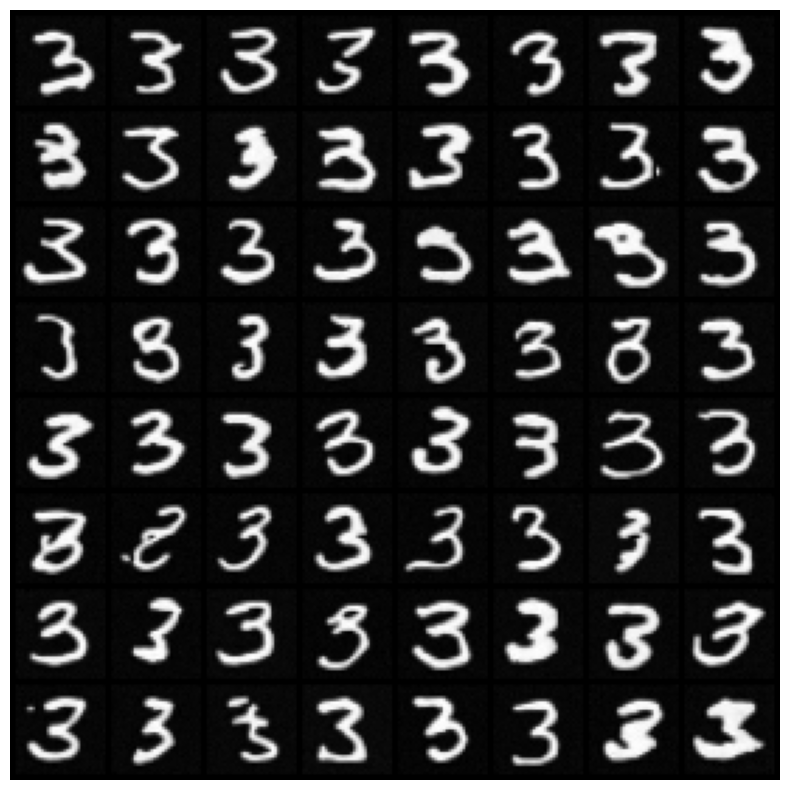

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    class_label=3,
    T=1,
    sigma=0.5,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:12<00:00, 41.51it/s]
<ipython-input-12-b11837549328>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
100%|██████████| 500/500 [00:11<00:00, 42.98it/s]


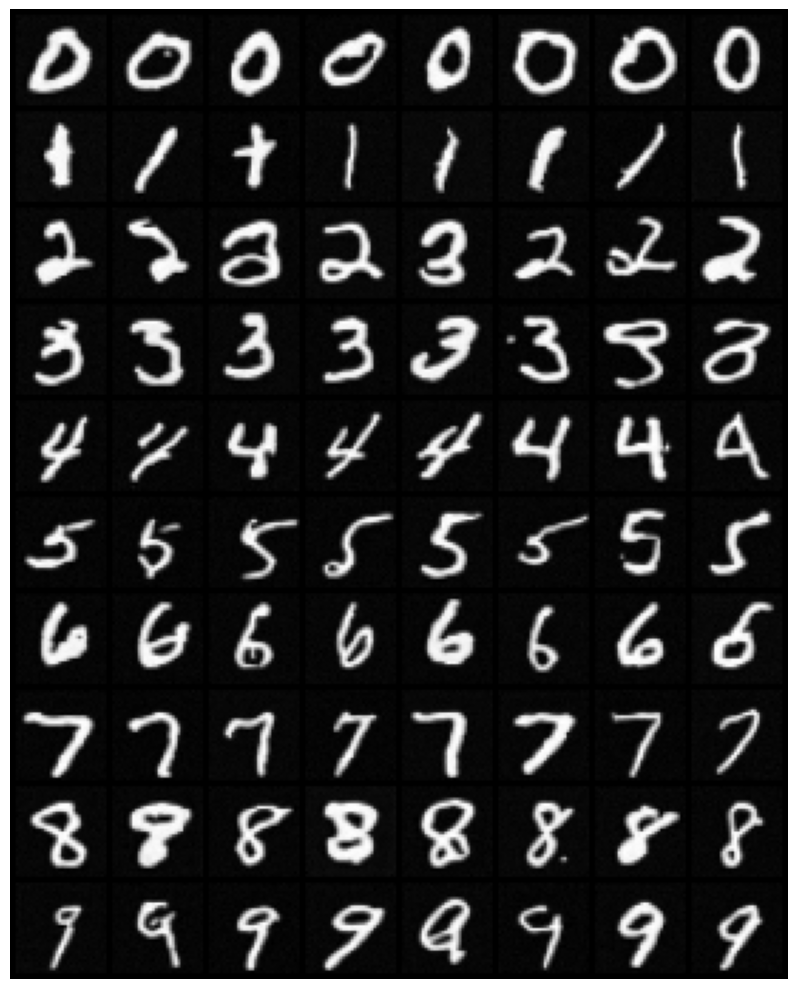

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# Initialize an empty list to store all samples
all_samples = []

# Loop over digit classes 0 through 9
for class_label in range(10):
    samples = sample(
        model=model,
        n_samples=8,
        steps=500,
        class_label=class_label,
        T=1,
        sigma=0.5,
        gif=False
    )

    # Stack and collect final step images
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    all_samples.append(final_step_images)

# Concatenate all class sample tensors into one tensor of shape (80, C, H, W)
all_samples_tensor = torch.cat(all_samples, dim=0)

# Create a grid with 8 rows and 10 columns
grid = make_grid(all_samples_tensor, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(12, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:02<00:00, 20.61it/s]
<ipython-input-11-e74e0d346af0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_images.append(torch.tensor(sample_result[0]).cpu())
100%|██████████| 500/500 [00:12<00:00, 38.60it/s]


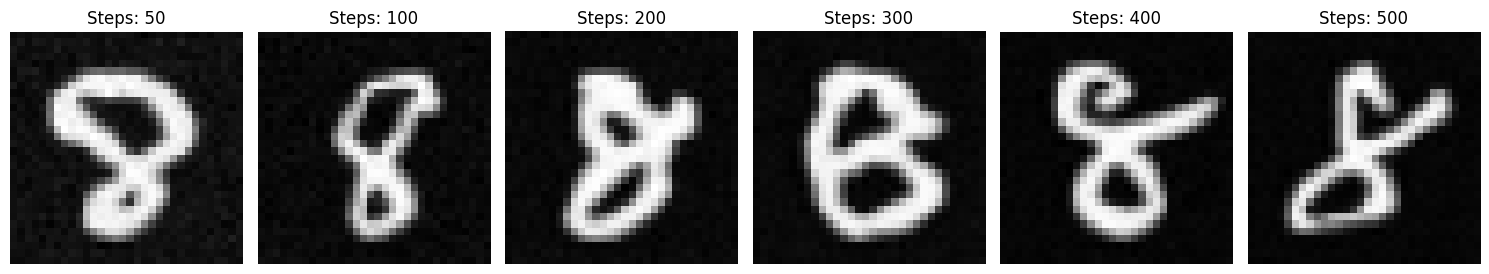

In [ ]:
import matplotlib.pyplot as plt
import torch

# List of steps at which to sample
steps_list = [50, 100, 200, 300, 400, 500]

# Collect one sample for each specified step count
sampled_images = []
for steps in steps_list:
    sample_result = sample(
        model=model,
        n_samples=1,
        steps=steps,
        class_label=8,
        T=1,
        gif=False
    )
    # Assume sample returns a list of numpy arrays or tensors
    sampled_images.append(torch.tensor(sample_result[0]).cpu())

# Plot each image individually
plt.figure(figsize=(15, 3))
for idx, image in enumerate(sampled_images):
    plt.subplot(1, len(steps_list), idx + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Steps: {steps_list[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## CIFAR10

### Unconditional

#### Training

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
import torch
import torch.nn.functional as F

def loss_fn(model, x_start, sigma, T):
    """
    Bridge matching loss function.

    Args:
        model: The neural network model that predicts the drift term
        x_start: The target samples (x_1) from the data distribution
        T: The maximum time value (typically 1.0)

    Returns:
        The calculated loss value
    """
    device = x_start.device
    x_1 = x_start  # target samples from data distribution
    batch_size = x_start.shape[0]

    # Sample from the prior distribution (standard normal)
    x_0 = torch.randn_like(x_1)

    # Sample time uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    t_expanded = match_last_dims(t, x_start.shape)

    # Compute the conditional mean and std for the bridge process
    mean_t = (1 - t_expanded/T) * x_0 + (t_expanded/T) * x_1
    std_t = sigma * torch.sqrt((t_expanded * (T - t_expanded)) / T)

    # Sample from the bridge process at time t
    x_t = mean_t + std_t * torch.randn_like(x_0)

    # Compute the target
    target = x_1

    # Normalize time to [0, 1]
    t_norm = t / T

    # Model prediction
    pred = model(x_t, t_norm)

    # MSE loss between predicted and target drift
    loss = F.mse_loss(pred, target)

    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data,_) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data, sigma=0.5, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "cifar_bridge_matching_unconditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
train(
    num_epochs=50,
    dataloader=cifar_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.0286
Epoch [2] Average Loss: 0.0256
Epoch [3] Average Loss: 0.0253
Epoch [4] Average Loss: 0.0248
Epoch [5] Average Loss: 0.0247
Epoch [6] Average Loss: 0.0244
Epoch [7] Average Loss: 0.0243
Epoch [8] Average Loss: 0.0243
Epoch [9] Average Loss: 0.0244
Epoch [10] Average Loss: 0.0241
Epoch [11] Average Loss: 0.0239
Epoch [12] Average Loss: 0.0240
Epoch [13] Average Loss: 0.0240
Epoch [14] Average Loss: 0.0240
Epoch [15] Average Loss: 0.0238
Epoch [16] Average Loss: 0.0238
Epoch [17] Average Loss: 0.0237
Epoch [18] Average Loss: 0.0238
Epoch [19] Average Loss: 0.0237
Epoch [20] Average Loss: 0.0239
Epoch [21] Average Loss: 0.0237
Epoch [22] Average Loss: 0.0239
Epoch [23] Average Loss: 0.0236
Epoch [24] Average Loss: 0.0236
Epoch [25] Average Loss: 0.0237
Epoch [26] Average Loss: 0.0236
Epoch [27] Average Loss: 0.0235
Epoch [28] Average Loss: 0.0235
Epoch [29] Average Loss: 0.0237
Epoch [30] Average Loss: 0.0236
Epoch [31] Average Loss:

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/cifar_bridge_matching_unconditioned.pth")

#### Generation

In [ ]:
model.load_state_dict(torch.load("trained/cifar_bridge_matching_unconditioned.pth"))
# model.load_state_dict(torch.load("trained/bridge_matching_unconditioned.pth", map_location=torch.device('cpu')))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T
            noise = torch.randn_like(xt)

            # Predict the clean x_t
            v = (model(xt, t_norm_batch) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    T=1,
    sigma=0.5,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

### Conditional

#### Training

In [ ]:
def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

In [ ]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

In [ ]:
import torch.nn.functional as F

def loss_fn(model, x_start, sigma, T, y):
    x_1 = x_start.to(device)
    batch_size = x_start.shape[0]

    x_0 = torch.randn_like(x_1)
    z = torch.randn_like(x_1)
    t = torch.rand(batch_size, device=x_0.device) * T

    # Sample t uniformly from [0, T]
    t_comp = match_last_dims(t, x_start.shape)
    noise_term = sigma * torch.sqrt(t_comp * (1 - t_comp)) * z
    x_t =(1-t_comp) * x_0 + t_comp * x_1 + noise_term

    target = x_1

    t_norm = t/T

    pred = model(x_t, t_norm, y=y)

    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(num_epochs, dataloader, model, optimizer, checkpoint_dir, device, T=1):
    print("Training on device:", device)

    model.train()

    epoch_losses = []


    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0


        for batch_idx, (data,y) in enumerate(dataloader):
            data = data.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Compute the training loss.
            loss = loss_fn(model, x_start=data,sigma=0.5, T=T, y=y.int())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(dataloader)


        epoch_losses.append(avg_loss)


        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    print("Training finished.")

    # Save the losses to a file
    loss_path = os.path.join(checkpoint_dir, "cifar_bridge_matching_conditioned.pt")
    torch.save(epoch_losses, loss_path)
    print(f"Saved losses to: {loss_path}")

    # Plotting the loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-3,
    betas=(0.9, 0.999))

In [ ]:
train(
    num_epochs=40,
    dataloader=cifar_loader,
    model=model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device = device
)

Training on device: cuda
Epoch [1] Average Loss: 0.1402
Epoch [2] Average Loss: 0.1127
Epoch [3] Average Loss: 0.1088
Epoch [4] Average Loss: 0.1061
Epoch [5] Average Loss: 0.1055
Epoch [6] Average Loss: 0.1049
Epoch [7] Average Loss: 0.1040
Epoch [8] Average Loss: 0.1041
Epoch [9] Average Loss: 0.1020
Epoch [10] Average Loss: 0.1021
Epoch [11] Average Loss: 0.1018
Epoch [12] Average Loss: 0.1013
Epoch [13] Average Loss: 0.1013
Epoch [14] Average Loss: 0.1015
Epoch [15] Average Loss: 0.0997
Epoch [16] Average Loss: 0.1002
Epoch [17] Average Loss: 0.1007
Epoch [18] Average Loss: 0.0992
Epoch [19] Average Loss: 0.1001
Epoch [20] Average Loss: 0.0994
Epoch [21] Average Loss: 0.0994
Epoch [22] Average Loss: 0.0996
Epoch [23] Average Loss: 0.0986
Epoch [24] Average Loss: 0.0981
Epoch [25] Average Loss: 0.0985
Epoch [26] Average Loss: 0.0996
Epoch [27] Average Loss: 0.0982
Epoch [28] Average Loss: 0.0996
Epoch [29] Average Loss: 0.0987
Epoch [30] Average Loss: 0.0977
Epoch [31] Average Loss:

RuntimeError: Parent directory checkpoints does not exist.

In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/cifar_bridge_matching_conditioned.pth")

#### Generation

In [ ]:
model.load_state_dict(torch.load("trained/cifar_bridge_matching_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T

            noise = torch.randn_like(xt)
            cond_class_label = torch.full((shape[0],), class_label, device=device)

            v = (model(xt, t_norm_batch, cond_class_label) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

100%|██████████| 500/500 [00:21<00:00, 23.29it/s]
<ipython-input-17-38aa89735970>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


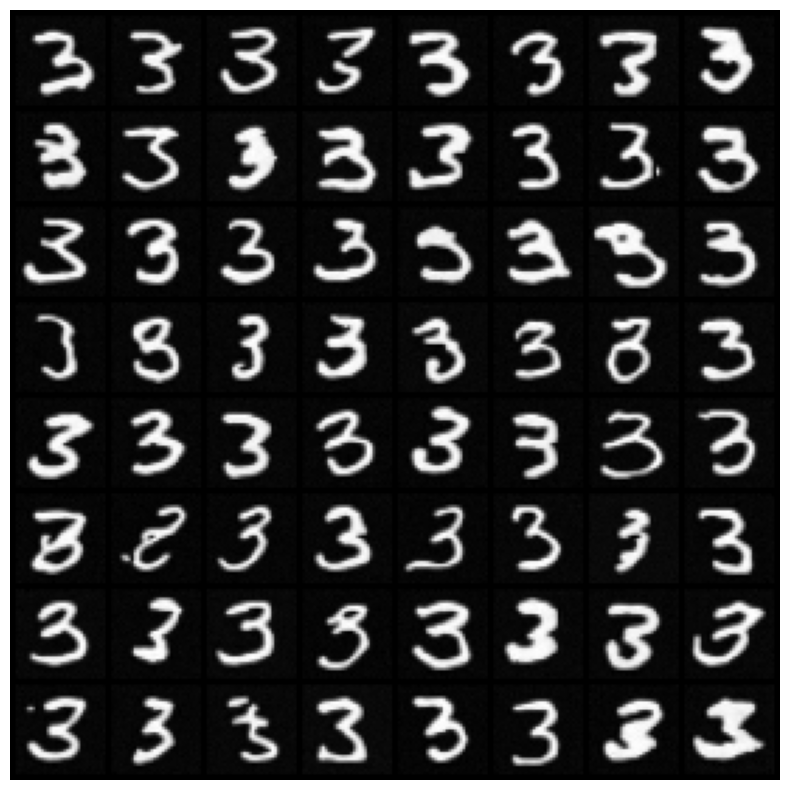

In [ ]:
from torchvision.utils import make_grid

samples = sample(
    model=model,
    n_samples=64,
    steps=500,
    class_label=3,
    T=1,
    sigma=0.5,
    gif=False
)

# Stack the final images into a tensor
final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])

# Create an 8x8 grid
grid = make_grid(final_step_images, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:12<00:00, 41.51it/s]
<ipython-input-12-b11837549328>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
100%|██████████| 500/500 [00:11<00:00, 42.98it/s]


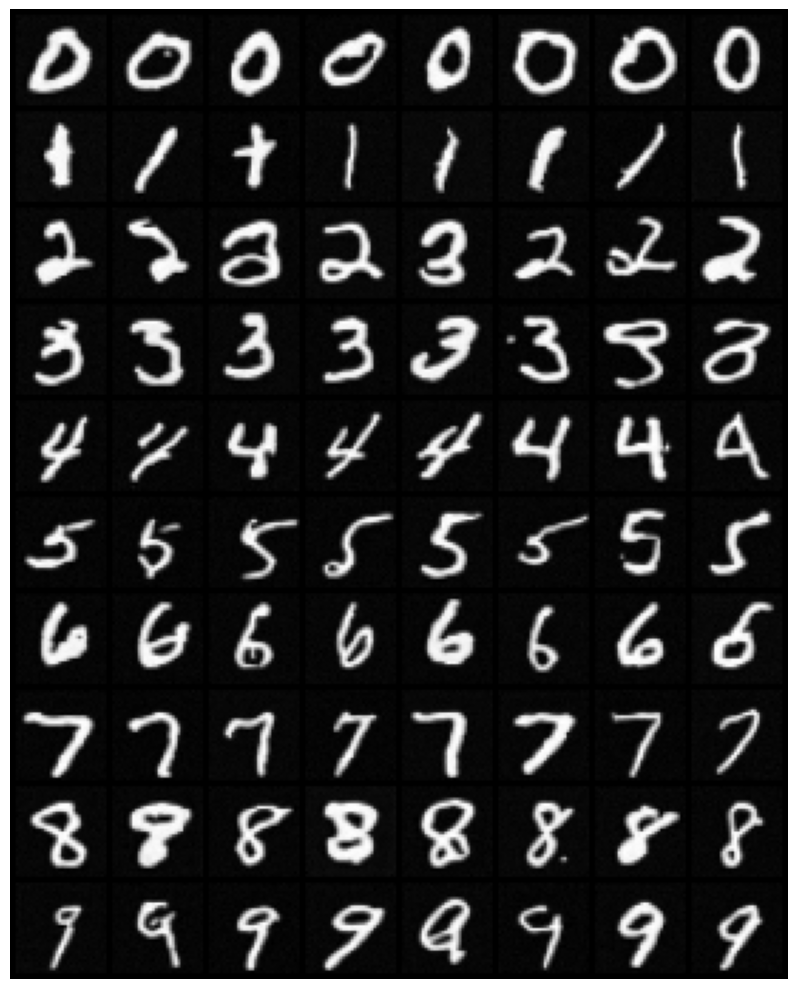

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# Initialize an empty list to store all samples
all_samples = []

# Loop over digit classes 0 through 9
for class_label in range(10):
    samples = sample(
        model=model,
        n_samples=4,
        steps=500,
        class_label=class_label,
        T=1,
        sigma=0.5,
        gif=False
    )

    # Stack and collect final step images
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    all_samples.append(final_step_images)

# Concatenate all class sample tensors into one tensor of shape (10*n_samples, C, H, W)
all_samples_tensor = torch.cat(all_samples, dim=0)

# Create a grid with 8 rows and 10 columns
grid = make_grid(all_samples_tensor, nrow=8, normalize=True, scale_each=True)

# Plot the grid
plt.figure(figsize=(12, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:02<00:00, 20.61it/s]
<ipython-input-11-e74e0d346af0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_images.append(torch.tensor(sample_result[0]).cpu())
100%|██████████| 500/500 [00:12<00:00, 38.60it/s]


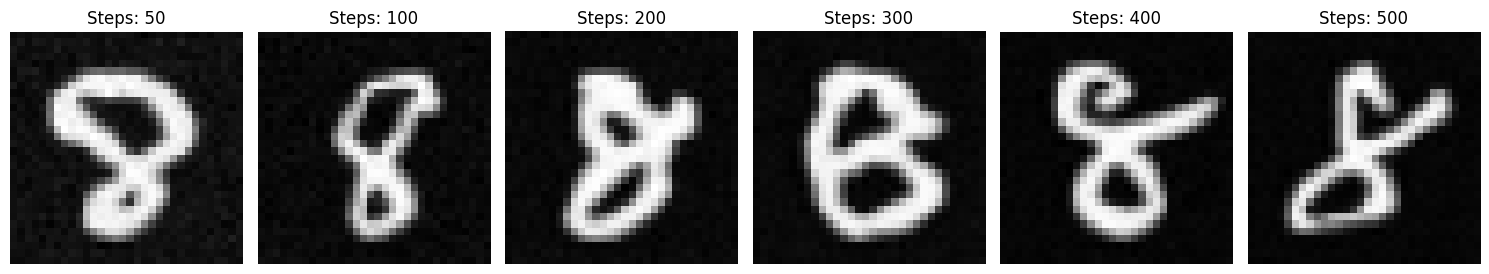

In [ ]:
import matplotlib.pyplot as plt
import torch

# List of steps at which to sample
steps_list = [50, 100, 200, 300, 400, 500]

# Collect one sample for each specified step count
sampled_images = []
for steps in steps_list:
    sample_result = sample(
        model=model,
        n_samples=1,
        steps=steps,
        class_label=8,
        T=1,
        gif=False
    )
    # Assume sample returns a list of numpy arrays or tensors
    sampled_images.append(torch.tensor(sample_result[0]).cpu())

# Plot each image individually
plt.figure(figsize=(15, 3))
for idx, image in enumerate(sampled_images):
    plt.subplot(1, len(steps_list), idx + 1)
    plt.imshow(image.squeeze())
    plt.title(f'Steps: {steps_list[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()